In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime as dt
from scipy.optimize import curve_fit
from matplotlib.ticker import StrMethodFormatter

from tpx_analysis import load_events, plot_raw_spectrum, plot_single_fit, plot_fit, fit_all
from tpx_analysis import chi2_red
from spectra_analysis import calibration, combine_new_key
from spectra_analysis import res_func, get_res, factory_res, log_eff, eff_energy


# config matplotlib
plt.rcParams['figure.figsize'] = ((16/9)*5.5, 5.5)
plt.rcParams['font.size'] = 13
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['figure.titlesize'] = 13
plt.rcParams['axes.titlepad'] = 11
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'lightsteelblue'
plt.rcParams['legend.facecolor'] = 'aliceblue'
plt.rcParams['legend.edgecolor'] = 'black'
plt.rcParams['legend.fancybox'] = True
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['savefig.dpi'] = 300


plt.rcParams['grid.linestyle'] = 'dotted'

FILEPATH_OUT = r"C:/Users/jonat/OneDrive - University College Dublin/10_Internship/Poster/figures/"

def file_save(fig, file_name):
    fig.tight_layout()
    fig.set_size_inches((16/9)*5, 5)
    fig.savefig(FILEPATH_OUT + file_name + ".png", transparent=True, dpi = 900)

### Load spectra

In [2]:
# Directory of the raw spectra files
DIR = ['main', 'icnas', 'point-source']

# Date of spectra acquisition, and geometry distance in mm
DATE = {
    'Na22': (dt(2023, 7, 4), 163, 5),
    'Ba133': (dt(2023, 7, 24), 165, 5),
    'Cs137': (dt(2023, 8, 2), 178, 5),
    'Na22-point-source': (dt(2023, 7, 30), (6+1.7+50+28.5+1.3)*10, 20),
    'Ba133-point-source': (dt(2023, 8, 1), (6+1.7+50+28.5+1.3)*10, 20),
    'Cs137-point-source': (dt(2023, 8, 3), (6+1.7+50+28.5+1.3)*10, 20),
    'Eu152': (dt(2023, 7, 7), 12, 5),
    'Eu154': (dt(2023, 7, 6), 29.5, 0.5),
    'background-night': (dt(2023, 6, 5), None),
    'Am241-10-degC': (dt(2023, 8, 18), 10, 2),
    'Am241-10': (dt(2023, 8, 18), 10, 2)
}

DATE = dict(sorted(DATE.items()))

events = load_events(DATE, DIR)

Text(0.5, 1.0, 'Raw Spectra, Pre-Calibrated Energy')

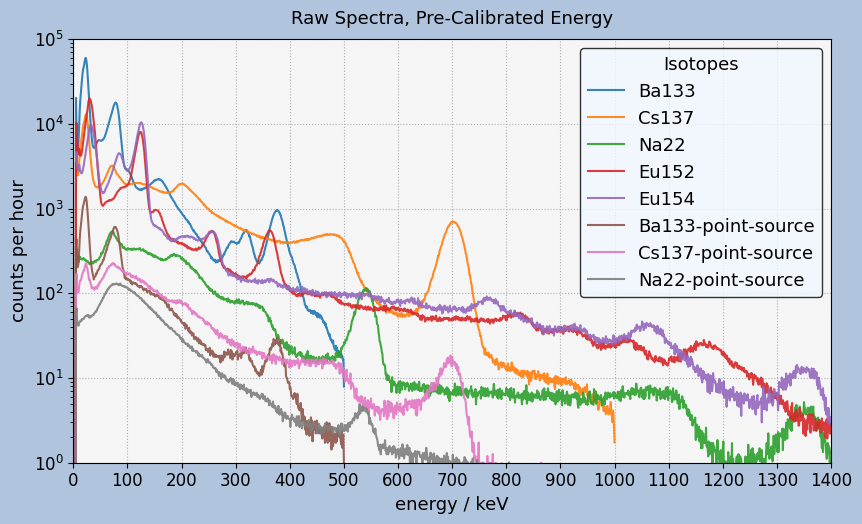

In [4]:
fig, ax = plt.subplots()

for key in events.keys():
    plot_raw_spectrum(ax, key, events)

ax.set_xticks(np.arange(0, 1401, 100))
ax.set_xlim(0, 1400)
ax.set_ylim(1, 1E5)
ax.legend(title = 'Isotopes', loc = 'upper right')
ax.set_title('Raw Spectra, Pre-Calibrated Energy')

# file_save(fig, 'raw_spectra')

### Define emission lines and emission fractions

In [4]:
# Energy of peaks in keV and their emission fractions
# tuple of energies if peaks overlap (e.g. 276.4 and 302.85 keV of Ba133)

peak_dict = {
    'Ba133':{
        'e0':[81.0, (276.4, 302.9), 356.0],
        'fractions':[33.31, 7.13, 18.31, 62.05],
        'fractions_err':[0.3, 0.06, 0.11, 0.19]
    },
    'Cs137':{
        'e0':[661.7],
        'fractions':[85.05],
        'fractions_err':[0.29]
    },
    'Na22':{
        'e0':[511.0, 1274.5],
        'fractions':[180.7, 99.94],
        'fractions_err':[0.2, 0.13]
    },
    "Eu152":{
        "e0":[121.8, 244.7, 344.3, (411.1, 444.0), 778.9, 1408.0],
        "fractions":[28.41, 7.55, 26.59, 2.24, 2.8, 12.97, 20.85],
        "fractions_err":[0.13, 0.04, 0.12, 0.01, 0.02, 0.06, 0.08]
    },
    "Eu154":{
        "e0":[123.1, 247.9, 591.8, 723.8, 873.2, 1274.4],
        "fractions":[40.4, 6.89, 4.95, 20.05, 12.17, 34.9],
        "fractions_err":[0.5, 0.07, 0.05, 0.21, 0.12, 0.3]
    }
}

if 'point-source' in DIR:
    peak_dict['Na22-point-source'] = {
        'e0':[511.0],
        'fractions':[180.7],
        'fractions_err':[0.2]}
    peak_dict['Ba133-point-source'] = {
        'e0':[81.0, 356.0],
        'fractions':[33.31, 62.05],
        'fractions_err':[0.3, 0.19]}
    peak_dict['Cs137-point-source'] = {
        'e0':[661.7],
        'fractions':[85.05],
        'fractions_err':[0.29]}

### Fitting of all individual peaks

single
fit parameters =  [7.04544053e+02 1.71337686e+01 2.16975600e+04 3.68436674e-02
 1.00000000e+00 9.36660210e-01 1.53671093e+01]
error [2.44093290e-01 7.67370190e-02 7.98568552e+02 1.64003571e-03
 2.16022940e-01 4.51106662e-02 1.37889869e-01]


Text(0.025, 0.96, '$E_{center} = (704.5\\pm0.2)$ keV\n$FWHM = (40.2\\pm0.2)$ keV\n$\\epsilon = (1.5\\pm0.2)$ %\n$\\chi^2_{red}$ = 0.2')

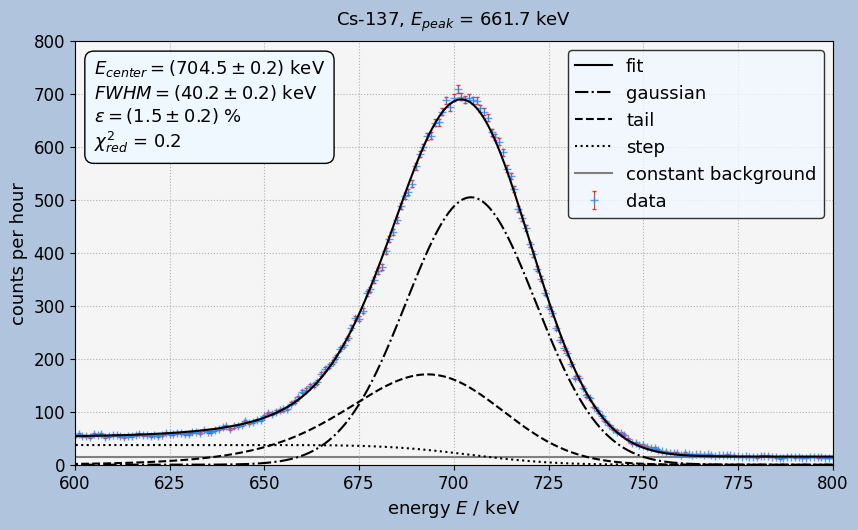

In [5]:
# lower and upper bounds of peaks to fit
# tuple if peaks overlap (e.g. 276.4 and 302.85 keV of Ba133)

peak_dict['Ba133']['lower'] = [60, (260, 305), 340]
peak_dict['Ba133']['upper'] = [105, (305, 345), 400]

peak_dict['Cs137']['lower'] = [590]
peak_dict['Cs137']['upper'] = [810]

peak_dict['Na22']['lower'] = [450, 1210]
peak_dict['Na22']['upper'] = [650, 1600]

peak_dict['Eu152']['lower'] = [100, 220, 310, (410, 440), 750, 1400]
peak_dict['Eu152']['upper'] = [150, 300, 410, (460, 510), 890, 1700]

peak_dict['Eu154']['lower'] = [100, 220, 570, 700, 880, 1220]
peak_dict['Eu154']['upper'] = [170, 300, 730, 810, 1000, 1500]

if 'point-source' in DIR:
    peak_dict['Na22-point-source']['lower'] = [450]
    peak_dict['Na22-point-source']['upper'] = [650]

    peak_dict['Ba133-point-source']['lower'] = [40, 340]
    peak_dict['Ba133-point-source']['upper'] = [120, 405]

    peak_dict['Cs137-point-source']['lower'] = [560]
    peak_dict['Cs137-point-source']['upper'] = [850]

# example fitting of Cs137 peak

fig, ax = plot_single_fit('Cs137', events, peak_dict, 0)
ax.set_ylim(0, 800)
ax.set_xlim(600, 800)
ax.set_xlabel(r'energy $E$ / keV')
ax.text(0.025, 0.96, r"$E_{center} = (704.5\pm0.2)$ keV" + '\n' + r"$FWHM = (40.2\pm0.2)$ keV" + '\n' + r"$\epsilon = (1.5\pm0.2)$ %" + '\n' + r"$\chi^2_{red}$ = 0.2", 
                 transform = plt.gca().transAxes, horizontalalignment='left', verticalalignment='top', bbox={'facecolor': 'aliceblue', 'alpha': 1, 'pad': 0.5, 'edgecolor':'black', 'boxstyle':'round'})


# file_save(fig, 'cs137-fit')

(0.0, 1700.0)

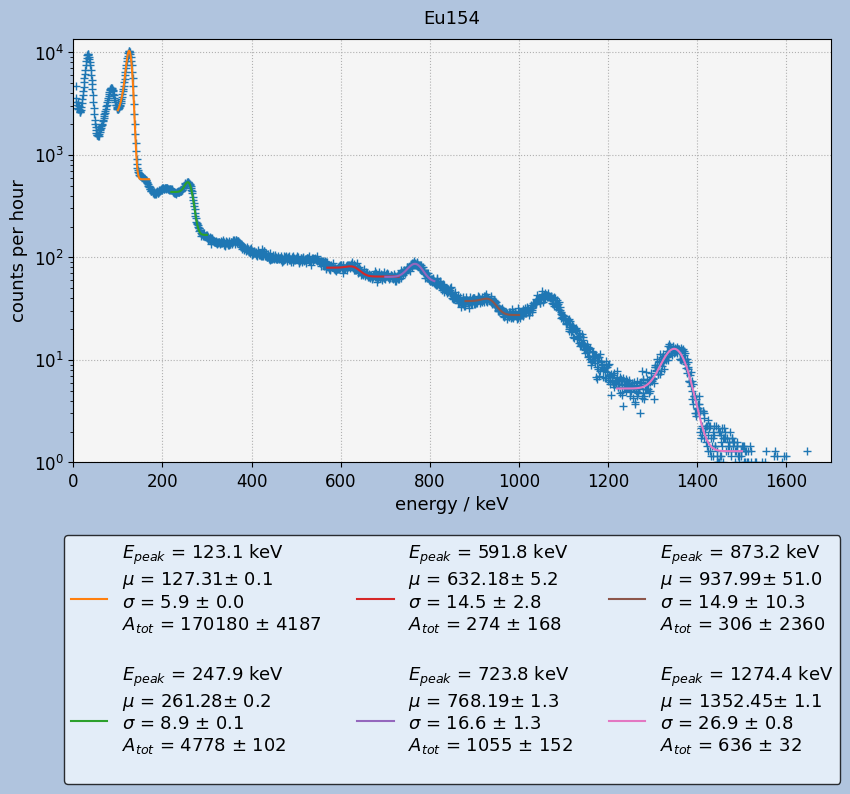

In [6]:
# example of fit of all Eu154 peaks

fig, ax = plot_fit("Eu154", events, peak_dict)
ax.set_xlim(0, 1700)

# file_save(fig, 'eu154-fit')

### Fit all peaks of all spectra

In [7]:
dfs = []
for key in events.keys():
    dfs.append(fit_all(key, events, peak_dict))
    print(f'{key} done')
df = pd.concat(dfs, axis=0, keys=list(events.keys()), names=['Isotope'])
df = df.set_index(['e0'], inplace=False, append=True).droplevel(1)


# replace value with np.nan if error is equal or larger than value
# to exclude from further analysis

def replace_err(df, key):
    df.loc[df[key+'_err'] >= df[key], key] = np.nan
    df.loc[df[key+'_err'] >= df[key], key+'_err'] = np.nan

for key in ['energy', 'sigma', 'A']:
    replace_err(df, key)

df_save = df.copy() #deep-copy of df to save for later anaylsis
df

Ba133 done
Cs137 done
Na22 done
Eu152 done
Eu154 done
Ba133-point-source done
Cs137-point-source done
Na22-point-source done


energy  energy_err      sigma  sigma_err  \
Isotope            e0                                                      
Ba133              81.0      80.435329    0.104676   5.566399   0.028638   
                   276.4    293.199769    1.623585   9.452320   0.614159   
                   302.9    319.347074    0.701633   8.668792   0.292058   
                   356.0    376.324332    3.490202  11.147141   0.663664   
Cs137              661.7    704.544053    0.244093  17.133769   0.076737   
Na22               511.0    542.733673    0.665473  13.851666   0.218130   
                   1274.5  1354.621623    3.853155  27.540083   1.394652   
Eu152              121.8    125.723302    0.080189   5.709990   0.025262   
                   244.7    257.078538    0.073471   8.981396   0.065118   
                   344.3    364.502730    0.418065  10.484079   0.136284   
                   411.1    439.567665    8.247028  10.262427   3.903997   
                   444.0    469.086537   13.938383  13.575420   4.693718   
                   778.9    825.638540    1.396686  18.183923   0.983262   
                   1408.0  1499.896403    1.931454  30.841266   0.946664   
Eu154              123.1    127.310296    0.109616   5.942861   0.029923   
                   247.9    261.282269    0.159462   8.851096   0.125701   
                   591.8    632.184541    5.208719  14.501888   2.781829   
                   723.8    768.186010    1.250528  16.635903   1.257087   
                   873.2    937.988120   50.966368  14.894462  10.309307   
                   1274.4  1352.449217    1.110667  26.905630   0.753814   
Ba133-point-source 81.0      79.069487    0.286235   6.976805   0.104800   
                   356.0    375.522632    0.329976  11.641193   0.354676   
Cs137-point-source 661.7    702.390330    1.445303  15.788349   0.518903   
Na22-point-source  511.0    537.616738    0.414241  13.683444   0.365413   

                                       A         A_err  
Isotope            e0                                   
Ba133              81.0    225813.077207   5568.064681  
                   276.4     3964.236269   1190.843403  
                   302.9     6942.065253   1048.347616  
                   356.0    40214.571154  30369.003203  
Cs137              661.7    43395.120072    798.568552  
Na22               511.0     5076.106887    307.542556  
                   1274.5     276.189693     63.828609  
Eu152              121.8   122717.404710   2149.146188  
                   244.7     6420.986326     55.345260  
                   344.3    14852.696401    871.577288  
                   411.1             NaN    629.938478  
                   444.0             NaN   1603.688608  
                   778.9      677.446458     84.023230  
                   1408.0     387.604007     36.006496  
Eu154              123.1   170179.936174   4186.973133  
                   247.9     4778.035995    102.109277  
                   591.8      274.256275    168.444324  
                   723.8     1055.362847    151.815349  
                   873.2             NaN   2359.969429  
                   1274.4     635.730134     32.370562  
Ba133-point-source 81.0      9671.404191    454.590717  
                   356.0      561.308478     21.828265  
Cs137-point-source 661.7      657.688119     72.271088  
Na22-point-source  511.0       80.441044      2.363175

### Analysis of results

#### Calibration

22.871233596793402


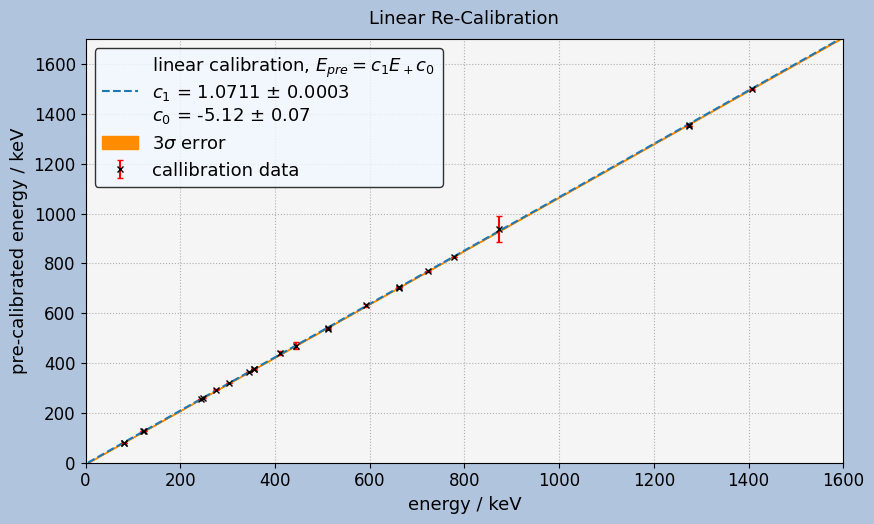

In [8]:
def linear(x, a, b):
    return a*x + b

popt, pcov = curve_fit(linear, df.index.get_level_values(1), df['energy'], sigma=df['energy_err'], absolute_sigma=True)

a = round(popt[0],4)
b = round(popt[1],2)
aerr = round(np.sqrt(np.diag(pcov))[0],4)
berr = round(np.sqrt(np.diag(pcov))[1],2)

fig, ax = plt.subplots()

ax.errorbar(df.index.get_level_values(1), df['energy'], yerr = df['energy_err'], fmt = 'x', label='callibration data', markersize=5, color = 'black', zorder=10, ecolor='red', capsize=2)

efine = np.linspace(5, 1600, 1000)

cal_err = np.sqrt((aerr*efine)**2 + berr**2)

ax.plot(efine, linear(efine, a, b), label = r'linear calibration, $E_{pre} = c_1 E_ + c_0$' +'\n' + r'$c_1$' + f' = {a} \u00B1 {aerr}' +'\n' + r'$c_0$' + f' = {b} \u00B1 {berr}', linestyle='dashed')
ax.fill_between(efine, linear(efine, a, b) - 3*cal_err, linear(efine, a, b) + 3*cal_err, alpha=1, color='darkorange', label = r'$3\sigma$ error')

ax.grid(linestyle = 'dotted')
ax.set_ylabel('pre-calibrated energy / keV')
ax.set_xlabel('energy / keV')
ax.set_title('Linear Re-Calibration')
ax.legend(loc='upper left')
ax.set_xlim(0, 1600)
ax.set_ylim(0, 1700)

print(chi2_red(df['energy'], linear(df.index.get_level_values(1), a, b), df['energy_err'], len(df['energy'])-len(popt)))

#file_save(fig, 'calibration')

#### Plot of calibrated spectrum

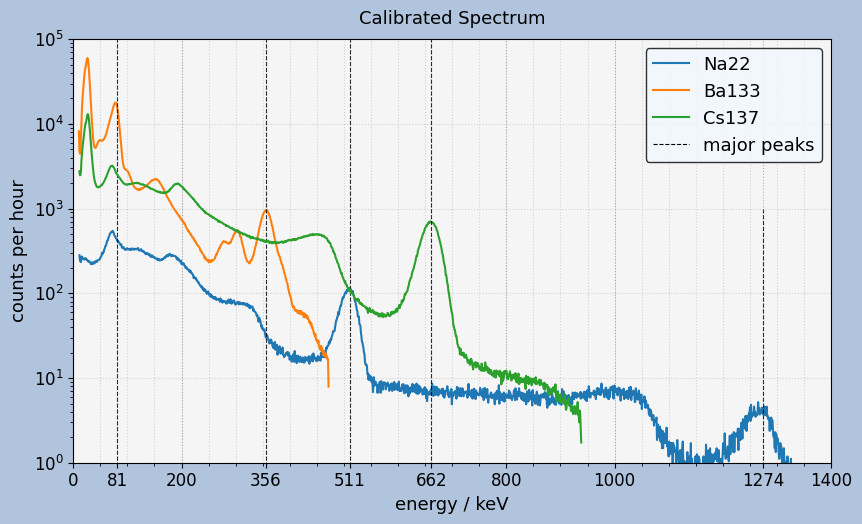

In [9]:
fig, ax = plt.subplots()

ticks = [0, 200, 800, 1000, 1400]

for tick in ticks:
     ax.vlines(tick, 0, 1e5, linestyle='dotted', color = 'k', alpha = 0.2, linewidth = 0.5)

for key in ['Na22', 'Ba133', 'Cs137']:
    energy, counts, counts_err = events[key][:,3:]
    energy = calibration(energy, a, b)
    ax.plot(energy, counts, label=key, linewidth=1.5, linestyle = "-", marker = 'none')
    for e0 in df.xs(key).index:
        if e0 > 350 or (e0 < 100 and e0 > 78):
            lim = 1e3 if e0 > 1000 else 1e5
            ax.vlines(e0, 0, lim, linestyle='--', linewidth = 0.8, color = 'black', alpha = 0.8)
            ticks.append(e0)

ax.vlines(-1, 0, 0, linestyle='--', linewidth = 0.8, color = 'black', label = 'major peaks')

from matplotlib.ticker import MultipleLocator
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.set_yscale('log')
ax.set_xticks(sorted(ticks))
ax.set_xlim(0, 1400)
ax.set_ylim(1, 1e5)
ax.set_xlabel('energy / keV')
ax.set_ylabel('counts per hour')
ax.set_title('Calibrated Spectrum')
ax.legend(loc='upper right')

ax.grid(linestyle = 'dotted', which='minor', axis = "x", alpha = 0.5)
ax.grid(linestyle = 'dotted', which='major', axis = "y", alpha = 0.5)

#file_save(fig, 'calibrated_spectrum')

#### Resolution

In [10]:
df = df_save.copy()

fres, fres_err = factory_res()
df[['res', 'res_err']] = combine_new_key(df, "get_resolution")

#exclue Ba133 peak because resolution is probably wrong due to Pb X-ray peaks
if 'point-source' in DIR:
    df.replace(df.loc['Ba133-point-source'].loc[81][['res', 'res_err']], np.nan, inplace=True)

60 keV: (22.0 ±0 10.6) %
122 keV: (13.9 ±0 5.2) %


paramter a: 10.356 ± 0.216
paramter b: 0.593 ± 0.038
paramter c: 0.050 ± 0.001
28.494223865009324


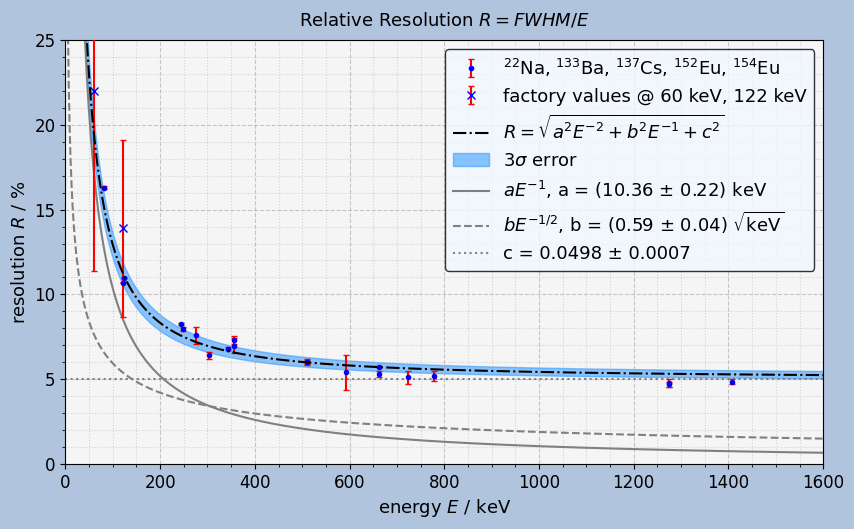

In [11]:
efine = np.linspace(5, 2000, 1000)

df = df.dropna()

popt, pcov = curve_fit(res_func, df.index.get_level_values(1), df['res']**2, sigma = df['res']*df['res_err']*2, absolute_sigma=True, bounds = ([0, 0, 0], [np.inf, np.inf, np.inf]))

_a, _b, _c, = popt
_aerr, _berr, _cerr = np.sqrt(np.diag(pcov))

print(f"paramter a: {_a:.3f} \u00B1 {_aerr:.3f}")
print(f"paramter b: {_b:.3f} \u00B1 {_berr:.3f}")
print(f"paramter c: {_c:.3f} \u00B1 {_cerr:.3f}")

res_fit, res_err = get_res(efine, popt, pcov)

print(chi2_red(df['res']**2, res_func(df.index.get_level_values(1), *popt), df['res']*df['res_err']*2, len(df['res'])-len(popt)))

fig, ax = plt.subplots()

ax.errorbar(df.index.get_level_values(1), df['res']*100, yerr=df['res_err']*100, fmt='.', label=r'$^{22}$Na, $^{133}$Ba, $^{137}$Cs, $^{152}$Eu, $^{154}$Eu', markersize=6, color='blue', zorder=10, ecolor='red', capsize=2)
ax.errorbar([60, 122], fres, yerr=fres_err, fmt='x', label='factory values @ 60 keV, 122 keV', markersize=6, color='blue', zorder=10, ecolor='red', capsize=2)
ax.plot(efine, res_fit, label=r'$R = \sqrt{a^2E^{-2} + b^2E^{-1} + c^2}$', alpha=1, linestyle='dashdot', zorder=20, color = 'black')
ax.fill_between(efine, res_fit - 3*res_err, res_fit + 3*res_err, alpha=0.5, color='dodgerblue', zorder=0, label=r"$3\sigma$ error")

ax.plot(efine, _a/efine*100, color = 'grey', label = r"$aE^{-1}$, " + f'a = ({_a:.2f} \u00B1 {_aerr:.2f}) keV', linestyle='-', alpha=1)
ax.plot(efine, _b/np.sqrt(efine)*100, color = 'grey', label = r"$bE^{-1/2}$, " + f'b = ({_b:.2f} \u00B1 {_berr:.2f})' + r" $\sqrt{\mathrm{keV}}$", linestyle='--', alpha=1)
ax.hlines(_c*100, 0, 1600 , color = 'grey', label = f'c = {_c:.4f} \u00B1 {_cerr:.4f}', linestyle='dotted', alpha=1)

ax.set_xlabel(r'energy $E$ / keV')
ax.set_ylabel(r'resolution $R$ / %')
ax.set_title(r'Relative Resolution $R = FWHM/E$')
ax.set_xlim(0, 1600)
ax.set_yticks(np.arange(0, 31, 5))
ax.set_ylim(0, 25)

handles, labels = ax.get_legend_handles_labels()
order = [5, 6, 0, 1, 2, 3, 4]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper right')

ax.minorticks_on()
ax.grid(linestyle='dotted', which='minor', axis="both", alpha=0.5)
ax.grid(linestyle='dashed', which='major', axis="both", alpha=0.7)

# file_save(fig, 'resolution')

#### Efficiency

In [12]:
df = df_save.copy()

df[['A_norm', 'A_norm_err']] = combine_new_key(df, "get_A_norm", peak_dict = peak_dict)
df[['A_rel', 'A_rel_err']] = combine_new_key(df, "get_A_rel", peak_dict = peak_dict)
df[['abs_eff', 'abs_eff_err']] = combine_new_key(df, "get_eff", eff_func = "relative_eff", events_dict = events)
df[['int_eff', 'int_eff_err']] = combine_new_key(df, "get_eff", eff_func = "intrinsic_eff", date=DATE)

df = df.dropna()
df.head(10)

energy  energy_err      sigma  sigma_err              A  \
Isotope e0                                                                     
Ba133   81.0      80.435329    0.104676   5.566399   0.028638  225813.077207   
        276.4    293.199769    1.623585   9.452320   0.614159    3964.236269   
        302.9    319.347074    0.701633   8.668792   0.292058    6942.065253   
        356.0    376.324332    3.490202  11.147141   0.663664   40214.571154   
Cs137   661.7    704.544053    0.244093  17.133769   0.076737   43395.120072   
Na22    511.0    542.733673    0.665473  13.851666   0.218130    5076.106887   
        1274.5  1354.621623    3.853155  27.540083   1.394652     276.189693   
Eu152   121.8    125.723302    0.080189   5.709990   0.025262  122717.404710   
        244.7    257.078538    0.073471   8.981396   0.065118    6420.986326   
        344.3    364.502730    0.418065  10.484079   0.136284   14852.696401   

                       A_err         A_norm    A_norm_err         A_rel  \
Isotope e0                                                                
Ba133   81.0     5568.064681  677913.771262  17796.017942  1.728680e+06   
        276.4    1190.843403   55599.386664  16708.423156  1.417784e+05   
        302.9    1048.347616   37914.064736   5730.075660  9.668087e+04   
        356.0   30369.003203   64809.945454  48943.195570  1.652654e+05   
Cs137   661.7     798.568552   51023.068868    954.922133  4.683918e+04   
Na22    511.0     307.542556    2809.134968    170.223503  7.865578e+03   
        1274.5     63.828609     276.355506     63.867941  7.737954e+02   
Eu152   121.8    2149.146188  431951.442133   7818.709407  8.941395e+05   
        244.7      55.345260   85046.176499    860.453683  1.760456e+05   
        344.3     871.577288   55858.203841   3287.517862  1.156265e+05   

                    A_rel_err   abs_eff  abs_eff_err   int_eff  int_eff_err  
Isotope e0                                                                   
Ba133   81.0     45379.845753  1.040458     0.027313  0.576561     0.094497  
        276.4    42606.479048  0.085334     0.025644  0.047287     0.016139  
        302.9    14611.692933  0.058190     0.008794  0.032246     0.007139  
        356.0   124805.148702  0.099470     0.075118  0.055120     0.042570  
Cs137   661.7      876.618518  0.058734     0.001099  0.014865     0.002397  
Na22    511.0      476.625808  0.086194     0.005223  0.025924     0.004485  
        1274.5     178.830235  0.008480     0.001960  0.002550     0.000720  
Eu152   121.8    16184.728473  1.129408     0.020443  0.278755     0.236083  
        244.7     1781.139123  0.222367     0.002250  0.054884     0.046475  
        344.3     6805.161974  0.146050     0.008596  0.036048     0.030596

[ 9.3297 -1.984 ]
[0.056  0.0101]


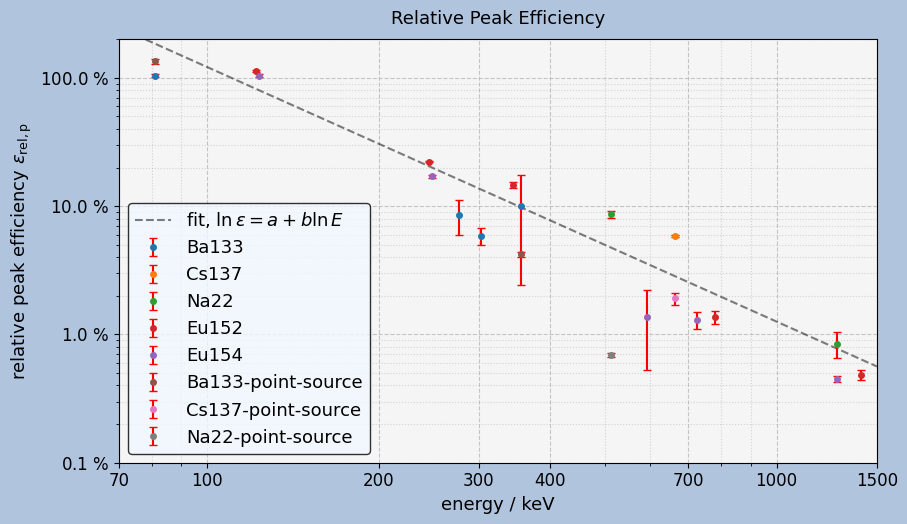

In [13]:
popt, pcov = curve_fit(log_eff, df.index.get_level_values(1), np.log(df['abs_eff']), sigma = df['abs_eff_err']/df['abs_eff'], absolute_sigma=True)

popt_rel = popt #save for later

print(np.round(popt,4))
print(np.round(np.sqrt(np.diag(pcov)),4))

efine = np.linspace(5, 1500, 1000)

fig, ax = plt.subplots()

ax.plot(efine, np.exp(log_eff(efine, *popt))*100, label=r'fit, $\ln\epsilon = a + b\ln E$', linestyle='dashed', color = 'black', alpha = 0.5)
for index in df.index.get_level_values(0).unique():
    ax.errorbar(df.loc[index].index, df.loc[index]['abs_eff']*100, yerr = df.loc[index]['abs_eff_err']*100, fmt = 'o', label=f'{index}', markersize=4, zorder=10, ecolor = 'red', capsize=3, alpha = 1)

ax.set_title('Relative Peak Efficiency')
ax.set_xlabel('energy / keV')
ax.set_ylabel(r'relative peak efficiency $\epsilon_\mathrm{rel,p}$')
ax.set_xlim(70, 1500)
ax.set_ylim(0.1, 200)
ax.legend()

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([70, 100, 200, 300, 400, 700, 1000, 1500])
ax.get_yaxis().set_major_formatter(StrMethodFormatter(r'{x:.1f} $\%$'))
ax.get_xaxis().set_major_formatter(StrMethodFormatter(r'{x:.0f}'))
ax.grid(which='both', axis = 'x')
ax.grid(linestyle = 'dotted', which='minor', axis = "both", alpha = 0.5)
ax.grid(linestyle = 'dashed', which='major', axis = "both", alpha = 0.7)

#file_save(fig, 'relative_efficiency')

In [14]:
# load theoretical peak efficiency

energy, compton, photo, pair, total = np.loadtxt('cdte_attenuation.txt', skiprows=1, unpack= True)

RHO_CDTE = 5.85 # g/cm^3

cross_sections = {
    'total attenuation': total*RHO_CDTE,
    'photoelectric absorption': photo*RHO_CDTE,
    'compton scattering': compton*RHO_CDTE,
    'pair production': pair*RHO_CDTE
}

energy = energy * 1000 # convert to keV

def p_eff(mu, t):
    return 1 - np.exp(-mu*t)

4.31344180926233


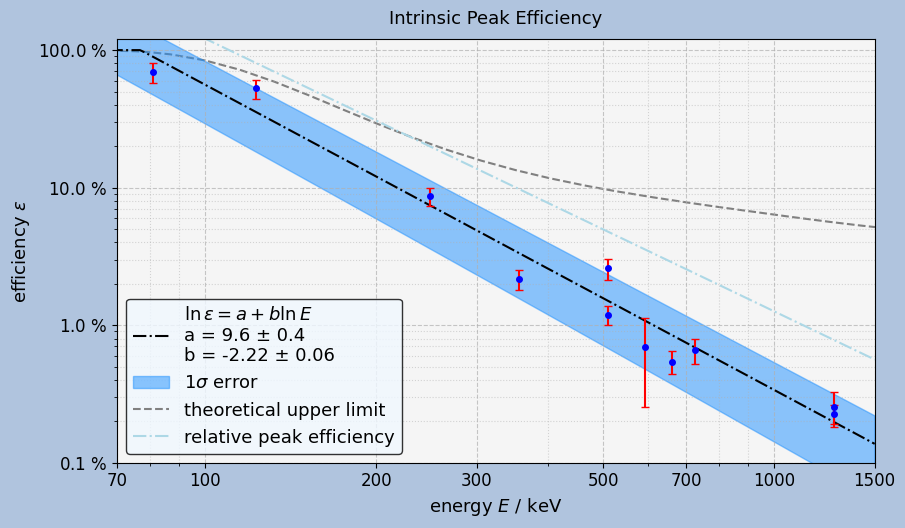

In [15]:
isotopes = ['Eu154', 'Na22', 'Na22-point-source', 'Ba133-point-source', 'Cs137-point-source']

popt, pcov = curve_fit(log_eff, df.loc[isotopes].index.get_level_values(1), np.log(df['int_eff'].loc[isotopes]), sigma = df['int_eff_err'].loc[isotopes]/df['int_eff'].loc[isotopes], absolute_sigma=True)

a_eff = popt[0]
a_eff_err = np.sqrt(np.diag(pcov))[0]
b_eff = popt[1]
b_eff_err = np.sqrt(np.diag(pcov))[1]

efine = np.linspace(5, 1500, 1000)

fig, ax = plt.subplots()

ax.errorbar(df.loc[isotopes].index.get_level_values(1), df['int_eff'].loc[isotopes]*100, yerr = df['int_eff_err'].loc[isotopes]*100, fmt = 'o',  label=r'$^{22}$Na, $^{133}$Ba, $^{137}$Cs, $^{152}$Eu, $^{154}$Eu', markersize=4, zorder=10, color = 'blue', ecolor = 'red', capsize=3)

eff, eff_err = eff_energy(efine, popt, pcov)

eff_err_neg = eff - eff_err
eff_err_pos = eff + eff_err

eff[eff > 100] = 100

label = r'$\ln\epsilon = a + b\ln E$' + f"\na = {a_eff:.1f} \u00B1 {a_eff_err:.1f}\nb = {b_eff:.2f} \u00B1 {b_eff_err:.2f}"

ax.plot(efine, np.exp(log_eff(efine, *popt_rel))*100, label=r'relative peak efficiency', linestyle='dashdot', color = 'lightblue')
ax.plot(energy, p_eff(cross_sections['total attenuation'], 0.2)*100, label='theoretical upper limit', linestyle='--', color = 'grey', zorder = 0)
ax.fill_between(efine, eff_err_neg, eff_err_pos, alpha=0.5, color = 'dodgerblue', zorder = 0, label = r"$1\sigma$ error")
ax.plot(efine, eff, label=label, linestyle='dashdot', color = 'black')

ax.set_title('Intrinsic Peak Efficiency')
ax.set_xlabel(r'energy $E$ / keV')
ax.set_ylabel(r'efficiency $\epsilon$')

order = np.flip([0,1,2,3])#np.arange(len(isotopes)+3))
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'lower left')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([50, 70, 100, 200, 300, 500, 700, 1000, 1500])
ax.get_yaxis().set_major_formatter(StrMethodFormatter(r'{x:.1f} $\%$'))
ax.get_xaxis().set_major_formatter(StrMethodFormatter(r'{x:.0f}'))

ax.set_ylim(0.1, 120)
ax.set_xlim(70, 1500)
ax.grid(which='both', axis = 'x')
ax.grid(linestyle = 'dotted', which='minor', axis = "both", alpha = 0.5)
ax.grid(linestyle = 'dashed', which='major', axis = "both", alpha = 0.7)

print(chi2_red(df['int_eff'].loc[isotopes], np.exp(log_eff(df.loc[isotopes].index.get_level_values(1), *popt)), df['int_eff_err'].loc[isotopes], len(df['int_eff'].loc[isotopes].to_list())-len(popt)))

# file_save(fig, 'intrinsic_efficiency')